In [19]:
import pandas as pd

# Lecture du fichier CSV
df = pd.read_csv('Books_rating_t.csv')
df2 = pd.read_csv('books_data_t.csv')

In [48]:
print(df.isnull().sum())
df = df.dropna(subset=['Titre'])
print(df.isnull().sum())
print(df2.isnull().sum())
df2 = df2.dropna(subset=['Titre'])
print(df2.isnull().sum())


Id                     0
Titre                  0
Prix             2518628
User_id           561774
Nom lecteur       561892
revue/utilité          0
revue/score            0
revue/heure            0
revue/résumé         407
revue/texte            8
dtype: int64
Id                     0
Titre                  0
Prix             2518628
User_id           561774
Nom lecteur       561892
revue/utilité          0
revue/score            0
revue/heure            0
revue/résumé         407
revue/texte            8
dtype: int64
Titre                    0
Description          68441
Auteurs              31413
Image                52075
Lien Google          23836
Editeur              75885
Date publication     25305
infoLink             23836
Genre                41198
Nb scores           162652
dtype: int64
Titre                    0
Description          68441
Auteurs              31413
Image                52075
Lien Google          23836
Editeur              75885
Date publication     25305
in

In [65]:
merged_df = pd.merge(df, df2, on='Titre')
merged_df.shape
merged_df.head(2)

,Id,Titre,Prix,User_id,Nom lecteur,revue/utilité,revue/score,revue/heure,revue/résumé,revue/texte,Description,Auteurs,Image,Lien Google,Editeur,Date publication,infoLink,Genre,Nb scores
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,01/01/2005,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN


In [27]:

print(len(merged_df[merged_df['Titre'] == "The Idea of History"]))
print(len(merged_df))
merged_df['Genre'].value_counts()

11
2999574


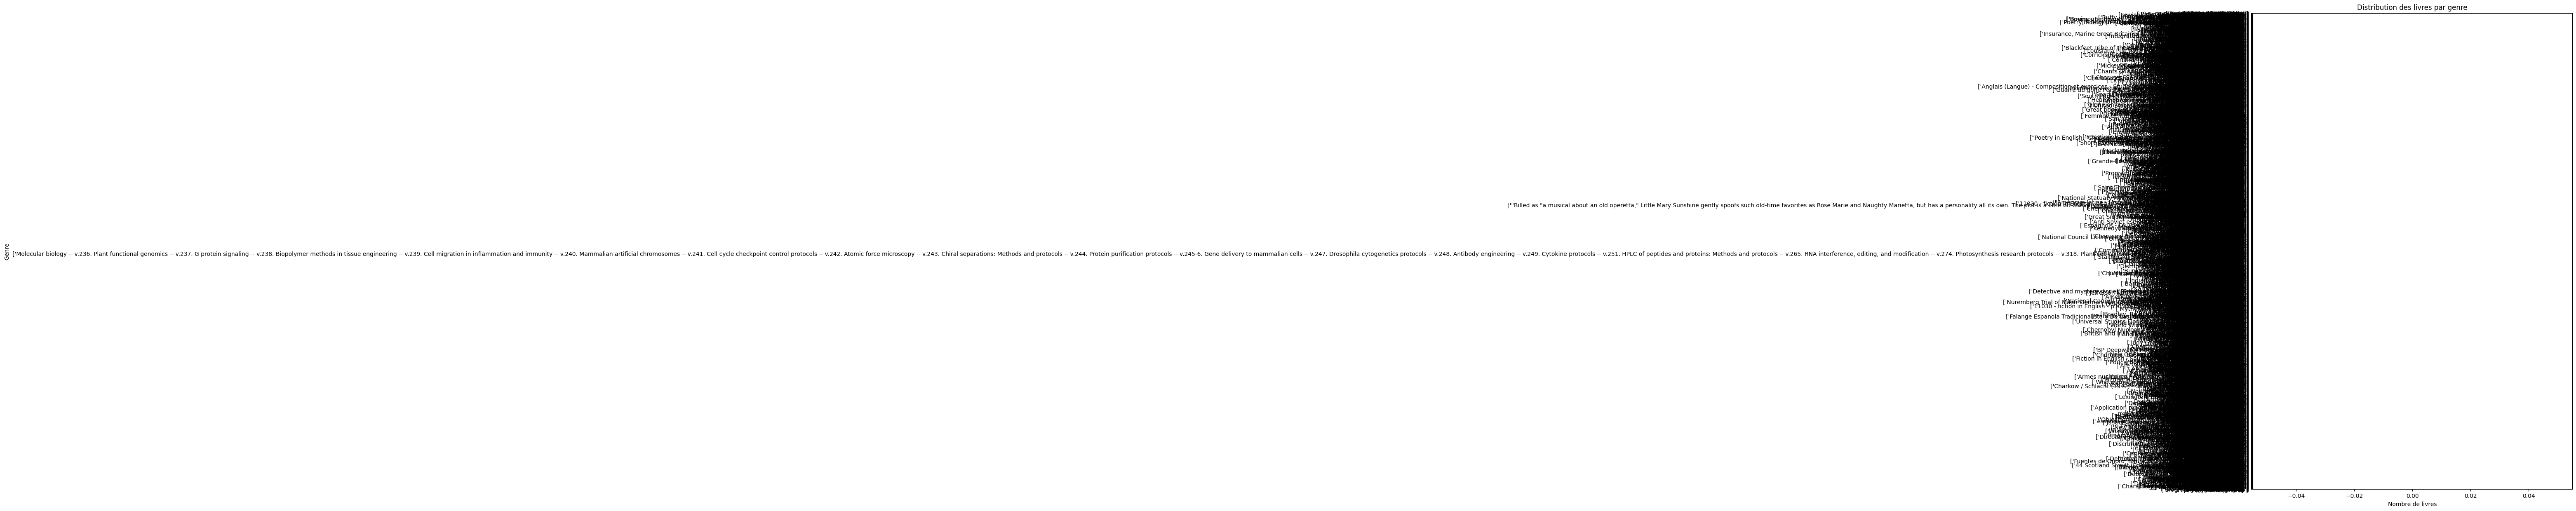

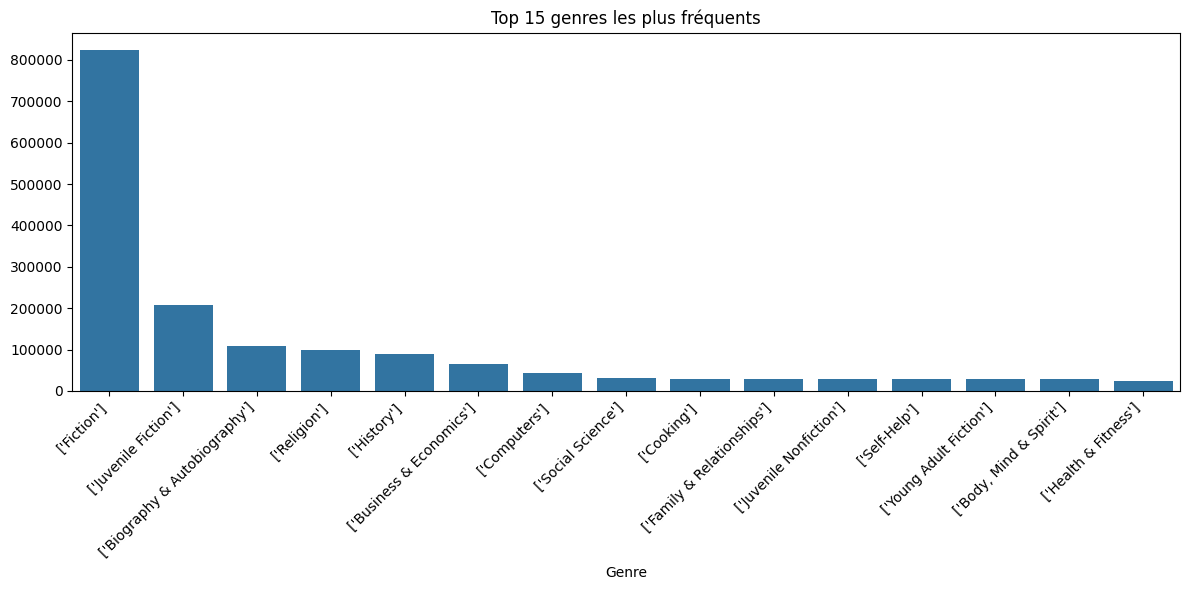

In [96]:
# 1. Barplot horizontal (recommandé pour une meilleure lisibilité)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 15))  # Ajuster la taille pour la lisibilité
sns.barplot(data=merged_df, 
           y='Genre',  # Genre sur l'axe Y pour une meilleure lecture
           x=merged_df.groupby('Genre').size(),  # Compte des occurrences
           order=merged_df.groupby('Genre').size().sort_values(ascending=True).index)  # Tri
plt.title('Distribution des livres par genre')
plt.xlabel('Nombre de livres')
plt.xticks(rotation=0)  # Rotation des labels si nécessaire

# 2. Alternative : Top N genres les plus fréquents
N = 15  # Ajuster selon vos besoins
top_genres = merged_df['Genre'].value_counts().nlargest(N)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.title(f'Top {N} genres les plus fréquents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

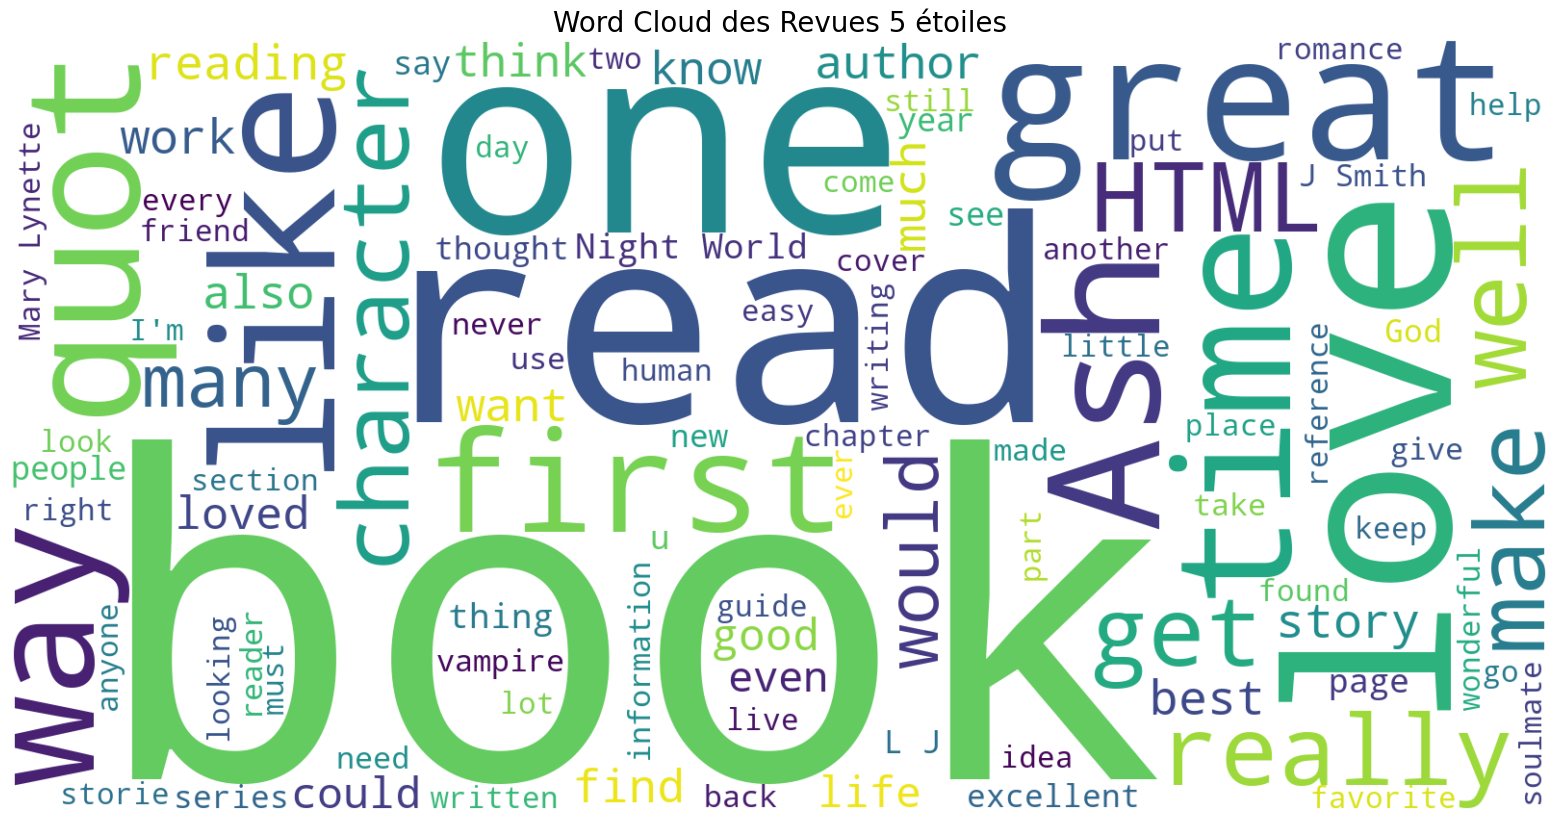

In [97]:
# 2. Les mots les plus fréquents dans les revues ayant obtenues un score >5
# (afficher sous forme de WordCloud)

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

qu =merged_df[merged_df['revue/score'] ==5]
note=qu.head(500)
text = ' '.join([str(texte) for texte in note['revue/texte'].values])

wordcloud = WordCloud(
    width=1600, 
    height=800,
    background_color='white',
    stopwords=set(stopwords.words('english')),
    max_words=100
).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud des Revues 5 étoiles', fontsize=20)
plt.show()



In [93]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# Séparation des features (X) et de la target (y)
X = merged_df.drop(columns=['revue/score'])
y = merged_df['revue/score']
le = OrdinalEncoder()
for colonne in X.select_dtypes(include=['object']).columns:
    X[[colonne]] = le.fit_transform(X[[colonne]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Aperçu des données encodées
print("Aperçu des données encodées :")
X.head()


Aperçu des données encodées :


,Id,Titre,Prix,User_id,Nom lecteur,revue/utilité,revue/heure,revue/résumé,revue/texte,Description,Auteurs,Image,Lien Google,Editeur,Date publication,infoLink,Genre,Nb scores
0,130698.0,83681.0,NaN,974296.0,354943.0,10402.0,940636800,928110.0,1770913.0,NaN,66141.0,35188.0,155829.0,NaN,7334.0,119925.0,3413.0,NaN
1,74263.0,47952.0,NaN,538900.0,410098.0,190.0,1095724800,1068185.0,532035.0,80015.0,96259.0,46233.0,158957.0,79.0,72.0,122372.0,1928.0,NaN
2,74263.0,47952.0,NaN,758520.0,363453.0,201.0,1078790400,466679.0,937901.0,80015.0,96259.0,46233.0,158957.0,79.0,72.0,122372.0,1928.0,NaN
3,74263.0,47952.0,NaN,436218.0,619472.0,10402.0,1090713600,1021908.0,1468867.0,80015.0,96259.0,46233.0,158957.0,79.0,72.0,122372.0,1928.0,NaN
4,74263.0,47952.0,NaN,288487.0,175368.0,6169.0,1107993600,581789.0,1239867.0,80015.0,96259.0,46233.0,158957.0,79.0,72.0,122372.0,1928.0,NaN


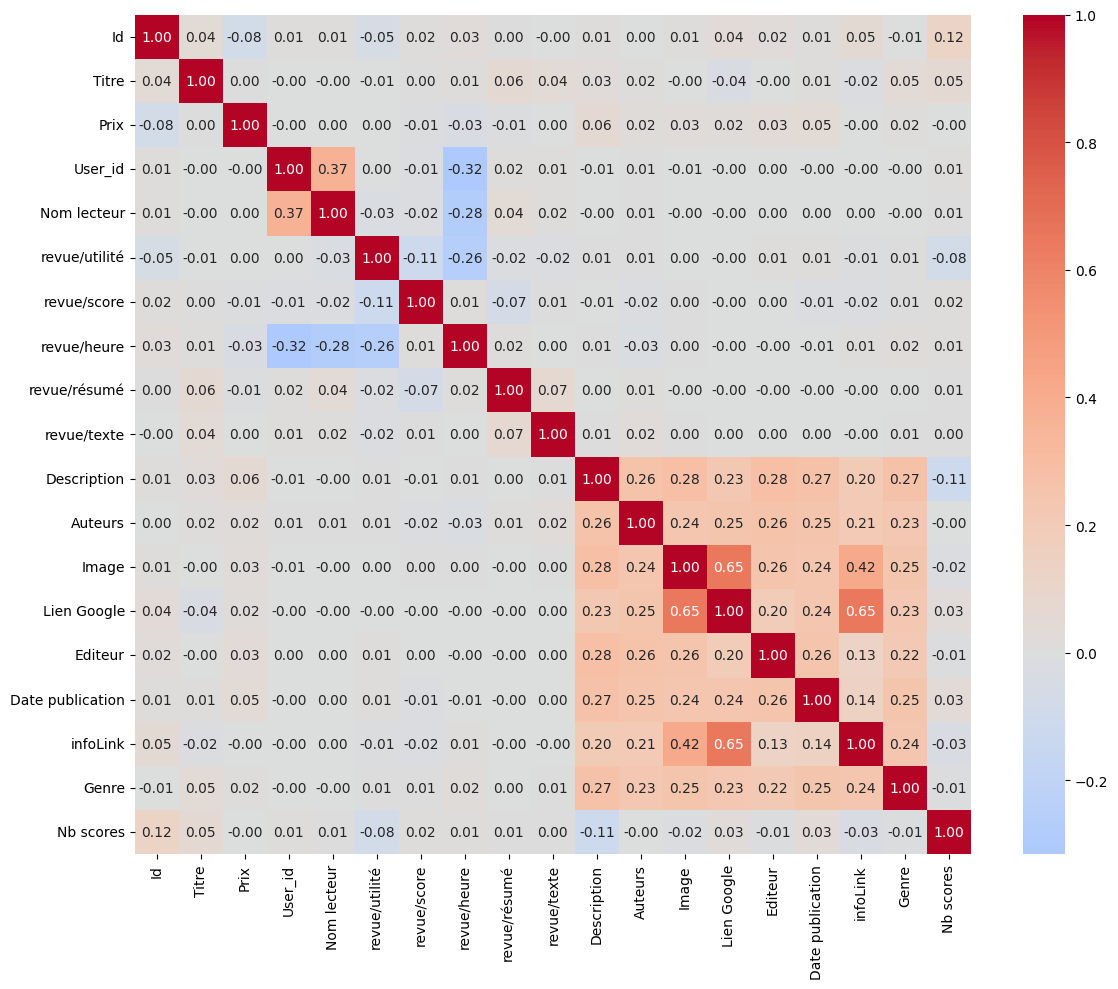

In [ ]:
# 8. Existe t-il une corrélation entre l’éditeur et le commentaire (score)
# 9. Existe-t-il une corrélation entre les auteurs et le commentaire (score).

# Créer la matrice de corrélation
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,        
            cmap='coolwarm',   
            center=0,         
            fmt='.2f')   


plt.tight_layout()
plt.show()

In [39]:
merged_df.head(2)

,Id,Titre,Prix,User_id,Nom lecteur,revue/utilité,revue/score,revue/heure,revue/résumé,revue/texte,Description,Auteurs,Image,Lien Google,Editeur,Date publication,infoLink,Genre,Nb scores
0,130698,83681,NaN,974296,354943,10402,4.0,940636800,928110,1770913,133185,66141,35188,155829,16014,7334,119925,3413,NaN
1,74263,47952,NaN,538900,410098,190,5.0,1095724800,1068185,532035,80015,96259,46233,158957,79,72,122372,1928,NaN
